## Imports

In [1]:
# Import libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Get the medal details dataset
df_medal_details = pd.read_csv('../data/etl/medals_by_season_country_discip_event_type.csv')
df_medal_details.head()

,game_season,country_code,country_name,discipline_title,event_title,event_gender,medal_type,medal_count
0,Summer,AFG,Afghanistan,Taekwondo,58 - 68 kg men,Men,BRONZE,1
1,Summer,AFG,Afghanistan,Taekwondo,beijing 2008 taekwondo - 58 kg men,Men,BRONZE,1
2,Summer,AHO,Netherlands Antilles,Sailing,division ii - windsurfer men,Open,SILVER,1
3,Summer,ALG,Algeria,Athletics,1500m men,Men,GOLD,2
4,Summer,ALG,Algeria,Athletics,1500m men,Men,SILVER,1


In [3]:
# Get all of the other datasets in the etl folder
df_hapiness = pd.read_csv('../data/etl/happiness_avg_by_country.csv')
df_gdp = pd.read_csv('../data/etl/gdp_avg_by_country.csv')
df_nutrition = pd.read_csv('../data/etl/nutrition_2017_by_country.csv')
df_nutrition.head()


,country_code,country_name,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population
0,ABW,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.361
1,AGO,Angola,57.2,87.1,7.1,92.9,17.0,26.0,27.7,29816.769
2,AIA,Anguilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALB,Albania,0.0,13.0,62.2,37.8,0.0,0.4,1.1,2873.457
4,ARE,United Arab Emirates,0.0,0.0,NaN,0.0,0.0,0.0,0.0,9487.206


In [4]:
# Unwanted columns - Simplify the dataset
unwanted_cols = [
    'support',
    'health',
    'freedom',
    'generosity',
    'corruption',
    'positivity',
    'negativity',
    'calories_pct',
    'nutrients_pct',
    'calories_mills',
    'nutrients_mills',
    'diet_mills'
]

## Functions

In [5]:
# Function to merge medals with happiness, GDP and nutrition datasets
def merge_hap_gdp_nut(df_medal_slice: pd.DataFrame) -> pd.DataFrame:
    df_merged = pd.merge(df_medal_slice, df_hapiness, on='country_name', how='left')
    df_merged = pd.merge(df_merged, df_gdp, on='country_name', how='left')
    df_merged = pd.merge(df_merged, df_nutrition, on='country_name', how='left')
    df_merged = df_merged.drop(columns=['country_code']).reset_index(drop=True)
    df_merged.drop(unwanted_cols, axis=1, inplace=True)
    return df_merged

In [6]:
# Function to slice the medal details dataset and prepare it for correlation
def slice_medal_details_data(data_to_select: dict[str, str]) -> pd.DataFrame:
    drop_medal_cols = ['game_season', 'country_code', 'discipline_title', 'event_title', 'event_gender', 'medal_type']
    group_medal_cols = ['country_name']

    df_slice = df_medal_details.copy()
    for key, value in data_to_select.items():
        df_slice = df_slice[df_slice[key] == value]

    df_slice = df_slice.drop(columns=drop_medal_cols)
    df_slice = df_slice.groupby(group_medal_cols)['medal_count'].sum().reset_index()
    return df_slice.reset_index(drop=True)

## Women's

In [7]:
# Women's summer games
data_to_select = {
    'game_season': 'Summer', 
    'event_gender': 'Women'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_name   103 non-null    object 
 1   medal_count    103 non-null    int64  
 2   happiness      85 non-null     float64
 3   wealth         84 non-null     float64
 4   gdp_avg        84 non-null     float64
 5   good_diet_pct  69 non-null     float64
 6   bad_diet_pct   72 non-null     float64
 7   population     76 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 6.6+ KB


In [8]:
# Set index to country_name and compare correlations
df.set_index('country_name').corr()

,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
medal_count,1.000000,0.234169,0.292613,0.831738,0.287825,-0.269807,0.313934
happiness,0.234169,1.000000,0.802930,0.208903,0.745038,-0.729592,-0.178541
wealth,0.292613,0.802930,1.000000,0.228058,0.897316,-0.890775,-0.159272
gdp_avg,0.831738,0.208903,0.228058,1.000000,0.210865,-0.197154,0.409605
good_diet_pct,0.287825,0.745038,0.897316,0.210865,1.000000,-1.000000,-0.151061
bad_diet_pct,-0.269807,-0.729592,-0.890775,-0.197154,-1.000000,1.000000,0.159740
population,0.313934,-0.178541,-0.159272,0.409605,-0.151061,0.159740,1.000000


In [9]:
# Set index to country_name and adjust for floats

df.set_index('country_name', inplace=True)
df_country_compare_women_summer = df.astype(float)
df_country_compare_women_summer

,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
country_name,,,,,,,
Algeria,3.0,5.391880,9.338236,79710.57,64.8,35.2,41389.174
Argentina,13.0,6.289722,10.028808,317986.22,89.0,11.0,44044.811
Australasia,2.0,NaN,NaN,NaN,NaN,NaN,NaN
Australia,216.0,7.242307,10.764977,521918.13,99.3,0.7,24601.860
Austria,21.0,7.178953,10.889285,197169.69,99.4,0.6,8797.566
...,...,...,...,...,...,...,...
Uzbekistan,1.0,5.865984,8.719908,36442.72,NaN,NaN,NaN
Venezuela,5.0,5.950996,8.588995,NaN,NaN,NaN,NaN
Vietnam,1.0,5.437579,8.977185,NaN,67.6,32.4,94600.643


In [10]:
df_variables_hypo = df.rename(columns={
    'medal_count': 'Medals Won',
    'happiness': 'Happiness',
    'wealth': 'Wealth',
    'gdp_avg': 'GDP per Capita',
    'good_diet_pct': 'Good Diet %',
    'bad_diet_pct': 'Bad Diet %',
    'population': 'Population'
}, inplace=True)

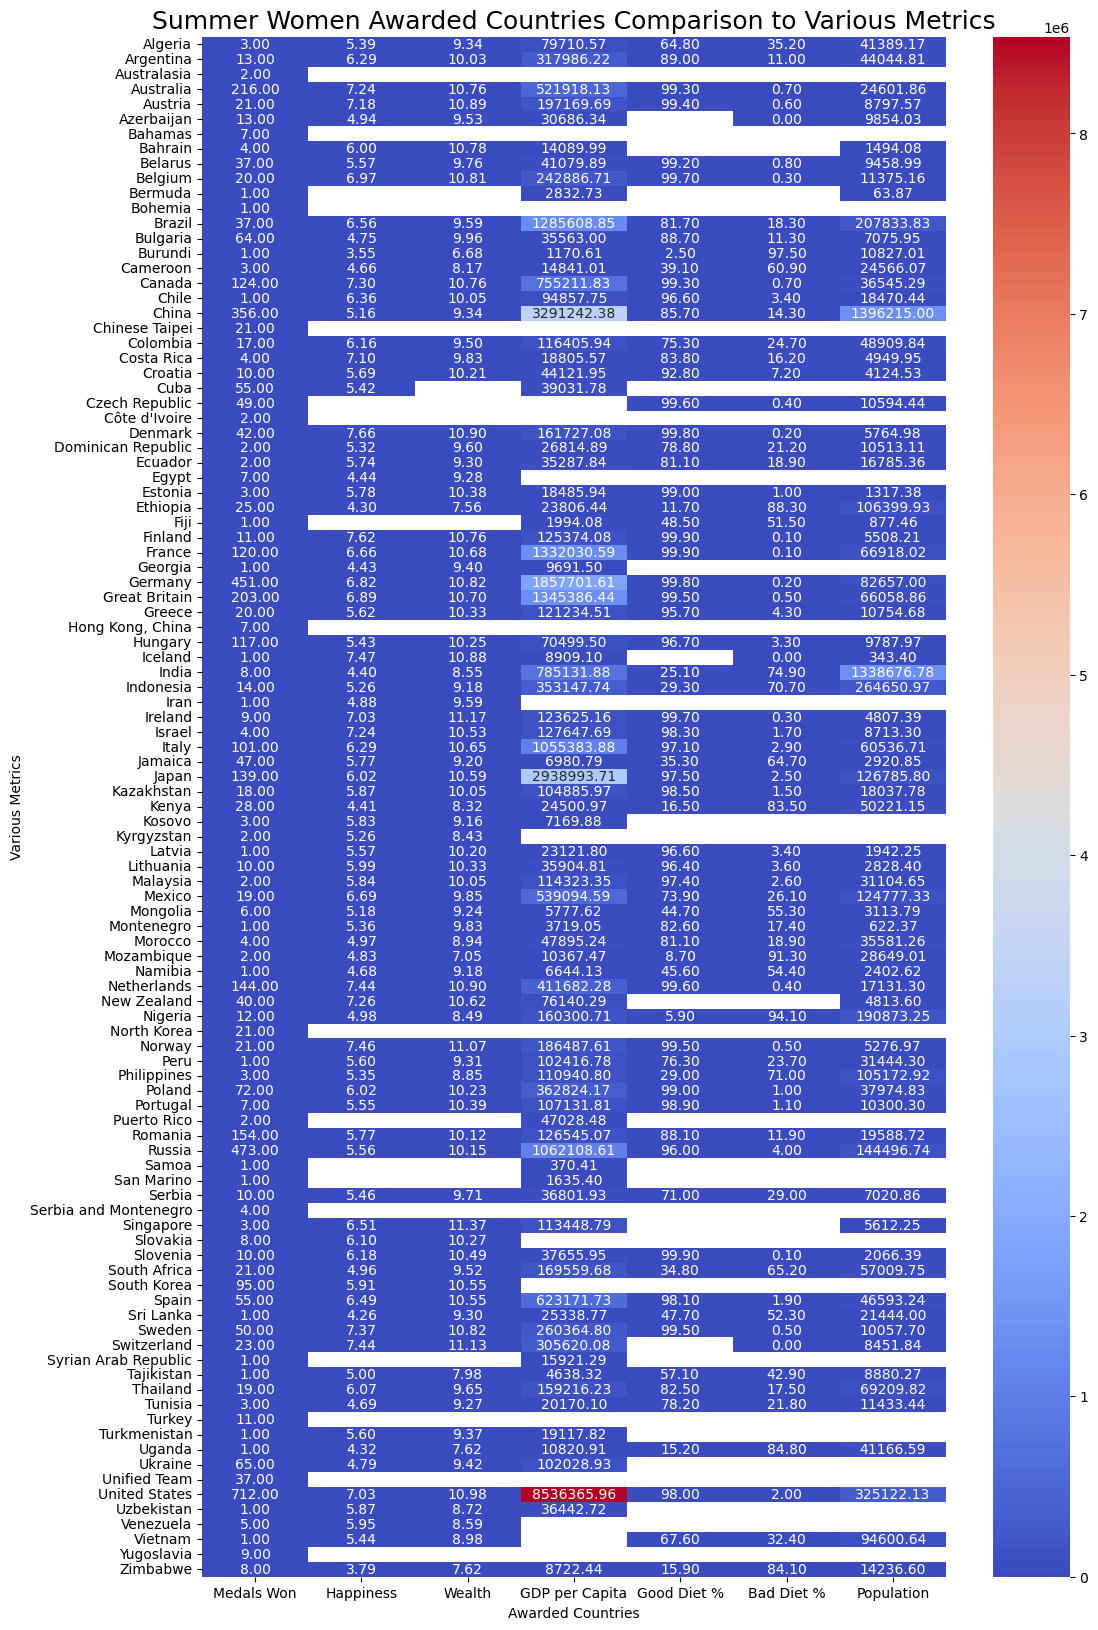

In [11]:
plt.figure(figsize=(12, 20))

# Create a heatmap
ax = sns.heatmap(df, annot=True, annot_kws={"size": 10}, cmap='coolwarm', fmt=".2f")
ax.set_xlabel("Awarded Countries")
ax.set_ylabel("Various Metrics")
plt.title('Summer Women Awarded Countries Comparison to Various Metrics', fontsize=18)
plt.show()

In [12]:
# Women's Winter games correlation
data_to_select = {
    'game_season': 'Winter', 
    'event_gender': 'Women'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.info()
df.set_index('country_name').corr()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_name   37 non-null     object 
 1   medal_count    37 non-null     int64  
 2   happiness      31 non-null     float64
 3   wealth         31 non-null     float64
 4   gdp_avg        30 non-null     float64
 5   good_diet_pct  26 non-null     float64
 6   bad_diet_pct   27 non-null     float64
 7   population     28 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.4+ KB


,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
medal_count,1.000000,0.293902,0.368509,0.497530,0.100702,-0.104417,0.141647
happiness,0.293902,1.000000,0.792075,0.025073,0.702636,-0.707371,-0.346490
wealth,0.368509,0.792075,1.000000,0.129109,0.718740,-0.719835,-0.528144
gdp_avg,0.497530,0.025073,0.129109,1.000000,-0.178119,0.185989,0.490593
good_diet_pct,0.100702,0.702636,0.718740,-0.178119,1.000000,-1.000000,-0.691285
bad_diet_pct,-0.104417,-0.707371,-0.719835,0.185989,-1.000000,1.000000,0.692564
population,0.141647,-0.346490,-0.528144,0.490593,-0.691285,0.692564,1.000000


In [13]:
# Top and Bottom Womens Winter Games
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='medal_count', ascending=False).reset_index(drop=True)
display(df.head())
display(df.tail())

,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,Germany,201,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
1,United States,139,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
2,Russia,126,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
3,Canada,100,7.296854,10.756211,755211.83,99.3,0.7,36545.295
4,Norway,79,7.463886,11.074348,186487.61,99.5,0.5,5276.968


,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
32,Spain,2,6.494954,10.547632,623171.73,98.1,1.9,46593.236
33,Denmark,1,7.664026,10.896594,161727.08,99.8,0.2,5764.980
34,Belgium,1,6.966089,10.812809,242886.71,99.7,0.3,11375.158
35,Uzbekistan,1,5.865984,8.719908,36442.72,NaN,NaN,NaN
36,Yugoslavia,1,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df.reset_index(drop=True, inplace=True)
df_country_compare_women = df.sort_values(by='country_name', ascending=True).reset_index(drop=True)
display(df_country_compare_women.head())
display(df_country_compare_women.tail())

,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,Australia,10,7.242307,10.764977,521918.13,99.3,0.7,24601.860
1,Austria,78,7.178953,10.889285,197169.69,99.4,0.6,8797.566
2,Belarus,11,5.571155,9.762316,41079.89,99.2,0.8,9458.989
3,Belgium,1,6.966089,10.812809,242886.71,99.7,0.3,11375.158
4,Bulgaria,5,4.751980,9.961130,35563.00,88.7,11.3,7075.947


,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
32,Ukraine,6,4.785123,9.421713,102028.93,NaN,NaN,NaN
33,Unified Team,15,NaN,NaN,NaN,NaN,NaN,NaN
34,United States,139,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
35,Uzbekistan,1,5.865984,8.719908,36442.72,NaN,NaN,NaN
36,Yugoslavia,1,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Set index to country_name and adjust for floats

df.set_index('country_name', inplace=True)

df_country_compare_women = df.astype(float)

df_country_compare_women


,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
country_name,,,,,,,
Germany,201.0,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
United States,139.0,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
Russia,126.0,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
Canada,100.0,7.296854,10.756211,755211.83,99.3,0.7,36545.295
Norway,79.0,7.463886,11.074348,186487.61,99.5,0.5,5276.968
Austria,78.0,7.178953,10.889285,197169.69,99.4,0.6,8797.566
Netherlands,64.0,7.440393,10.897109,411682.28,99.6,0.4,17131.296
Sweden,58.0,7.365232,10.822531,260364.80,99.5,0.5,10057.698
Switzerland,55.0,7.435587,11.125057,305620.08,NaN,0.0,8451.840


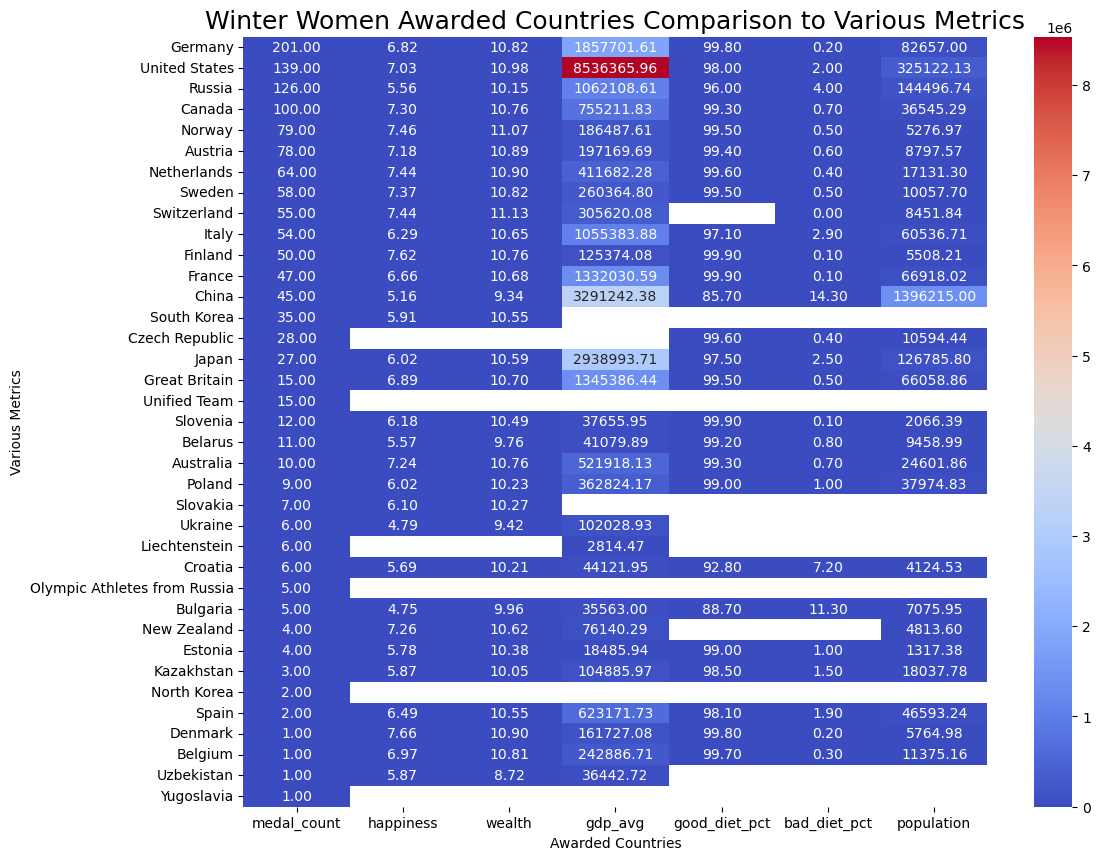

In [16]:
plt.figure(figsize=(12, 10))

# Create a heatmap
ax = sns.heatmap(df_country_compare_women, annot=True, annot_kws={"size": 10}, cmap='coolwarm', fmt=".2f")
ax.set_xlabel("Awarded Countries")
ax.set_ylabel("Various Metrics")
plt.title('Winter Women Awarded Countries Comparison to Various Metrics', fontsize=18)
plt.show()

## Men's

In [17]:
# Men's summer games correlation
data_to_select = {
    'game_season': 'Summer', 
    'event_gender': 'Men'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.info()
df.set_index('country_name').corr()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_name   136 non-null    object 
 1   medal_count    136 non-null    int64  
 2   happiness      110 non-null    float64
 3   wealth         109 non-null    float64
 4   gdp_avg        112 non-null    float64
 5   good_diet_pct  89 non-null     float64
 6   bad_diet_pct   93 non-null     float64
 7   population     102 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 8.6+ KB


,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
medal_count,1.000000,0.302195,0.323346,0.838378,0.335520,-0.318831,0.180862
happiness,0.302195,1.000000,0.825564,0.220894,0.765472,-0.756928,-0.125130
wealth,0.323346,0.825564,1.000000,0.219088,0.884786,-0.881313,-0.123776
gdp_avg,0.838378,0.220894,0.219088,1.000000,0.224338,-0.210609,0.421530
good_diet_pct,0.335520,0.765472,0.884786,0.224338,1.000000,-1.000000,-0.112098
bad_diet_pct,-0.318831,-0.756928,-0.881313,-0.210609,-1.000000,1.000000,0.121600
population,0.180862,-0.125130,-0.123776,0.421530,-0.112098,0.121600,1.000000


In [18]:
# Top and Bottom Mens Summer Games
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='medal_count', ascending=False).reset_index(drop=True)
display(df.head())
display(df.tail())

,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,United States,1793,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
1,Russia,992,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
2,Germany,793,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
3,Great Britain,617,6.889592,10.695583,1345386.44,99.5,0.5,66058.859
4,France,554,6.659597,10.681801,1332030.59,99.9,0.1,66918.020


,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
131,Iraq,1,4.774596,9.109163,70166.73,46.7,53.3,37552.789
132,Tonga,1,NaN,NaN,231.03,NaN,NaN,NaN
133,Togo,1,3.719667,7.550613,2674.59,NaN,NaN,7698.476
134,Mauritius,1,5.849597,9.976086,4751.99,85.2,14.8,1264.613
135,Sudan,1,4.378741,8.475512,21197.29,13.7,86.3,40813.398


In [19]:
# Men's Summer games correlation
data_to_select = {
    'game_season': 'Summer', 
    'event_gender': 'Men'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.info()
df.set_index('country_name').corr()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_name   136 non-null    object 
 1   medal_count    136 non-null    int64  
 2   happiness      110 non-null    float64
 3   wealth         109 non-null    float64
 4   gdp_avg        112 non-null    float64
 5   good_diet_pct  89 non-null     float64
 6   bad_diet_pct   93 non-null     float64
 7   population     102 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 8.6+ KB


,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
medal_count,1.000000,0.302195,0.323346,0.838378,0.335520,-0.318831,0.180862
happiness,0.302195,1.000000,0.825564,0.220894,0.765472,-0.756928,-0.125130
wealth,0.323346,0.825564,1.000000,0.219088,0.884786,-0.881313,-0.123776
gdp_avg,0.838378,0.220894,0.219088,1.000000,0.224338,-0.210609,0.421530
good_diet_pct,0.335520,0.765472,0.884786,0.224338,1.000000,-1.000000,-0.112098
bad_diet_pct,-0.318831,-0.756928,-0.881313,-0.210609,-1.000000,1.000000,0.121600
population,0.180862,-0.125130,-0.123776,0.421530,-0.112098,0.121600,1.000000


In [20]:
# Top and Bottom Mens Summer Games
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='medal_count', ascending=False).reset_index(drop=True)
display(df.head())
display(df.tail())

,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,United States,1793,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
1,Russia,992,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
2,Germany,793,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
3,Great Britain,617,6.889592,10.695583,1345386.44,99.5,0.5,66058.859
4,France,554,6.659597,10.681801,1332030.59,99.9,0.1,66918.020


,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
131,Iraq,1,4.774596,9.109163,70166.73,46.7,53.3,37552.789
132,Tonga,1,NaN,NaN,231.03,NaN,NaN,NaN
133,Togo,1,3.719667,7.550613,2674.59,NaN,NaN,7698.476
134,Mauritius,1,5.849597,9.976086,4751.99,85.2,14.8,1264.613
135,Sudan,1,4.378741,8.475512,21197.29,13.7,86.3,40813.398


In [21]:
# Set index to country_name and adjust for floats

df.set_index('country_name', inplace=True)

df_country_compare_men_summer = df.astype(float)

df_country_compare_men_summer

,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
country_name,,,,,,,
United States,1793.0,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
Russia,992.0,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
Germany,793.0,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
Great Britain,617.0,6.889592,10.695583,1345386.44,99.5,0.5,66058.859
France,554.0,6.659597,10.681801,1332030.59,99.9,0.1,66918.020
...,...,...,...,...,...,...,...
Iraq,1.0,4.774596,9.109163,70166.73,46.7,53.3,37552.789
Tonga,1.0,NaN,NaN,231.03,NaN,NaN,NaN
Togo,1.0,3.719667,7.550613,2674.59,NaN,NaN,7698.476


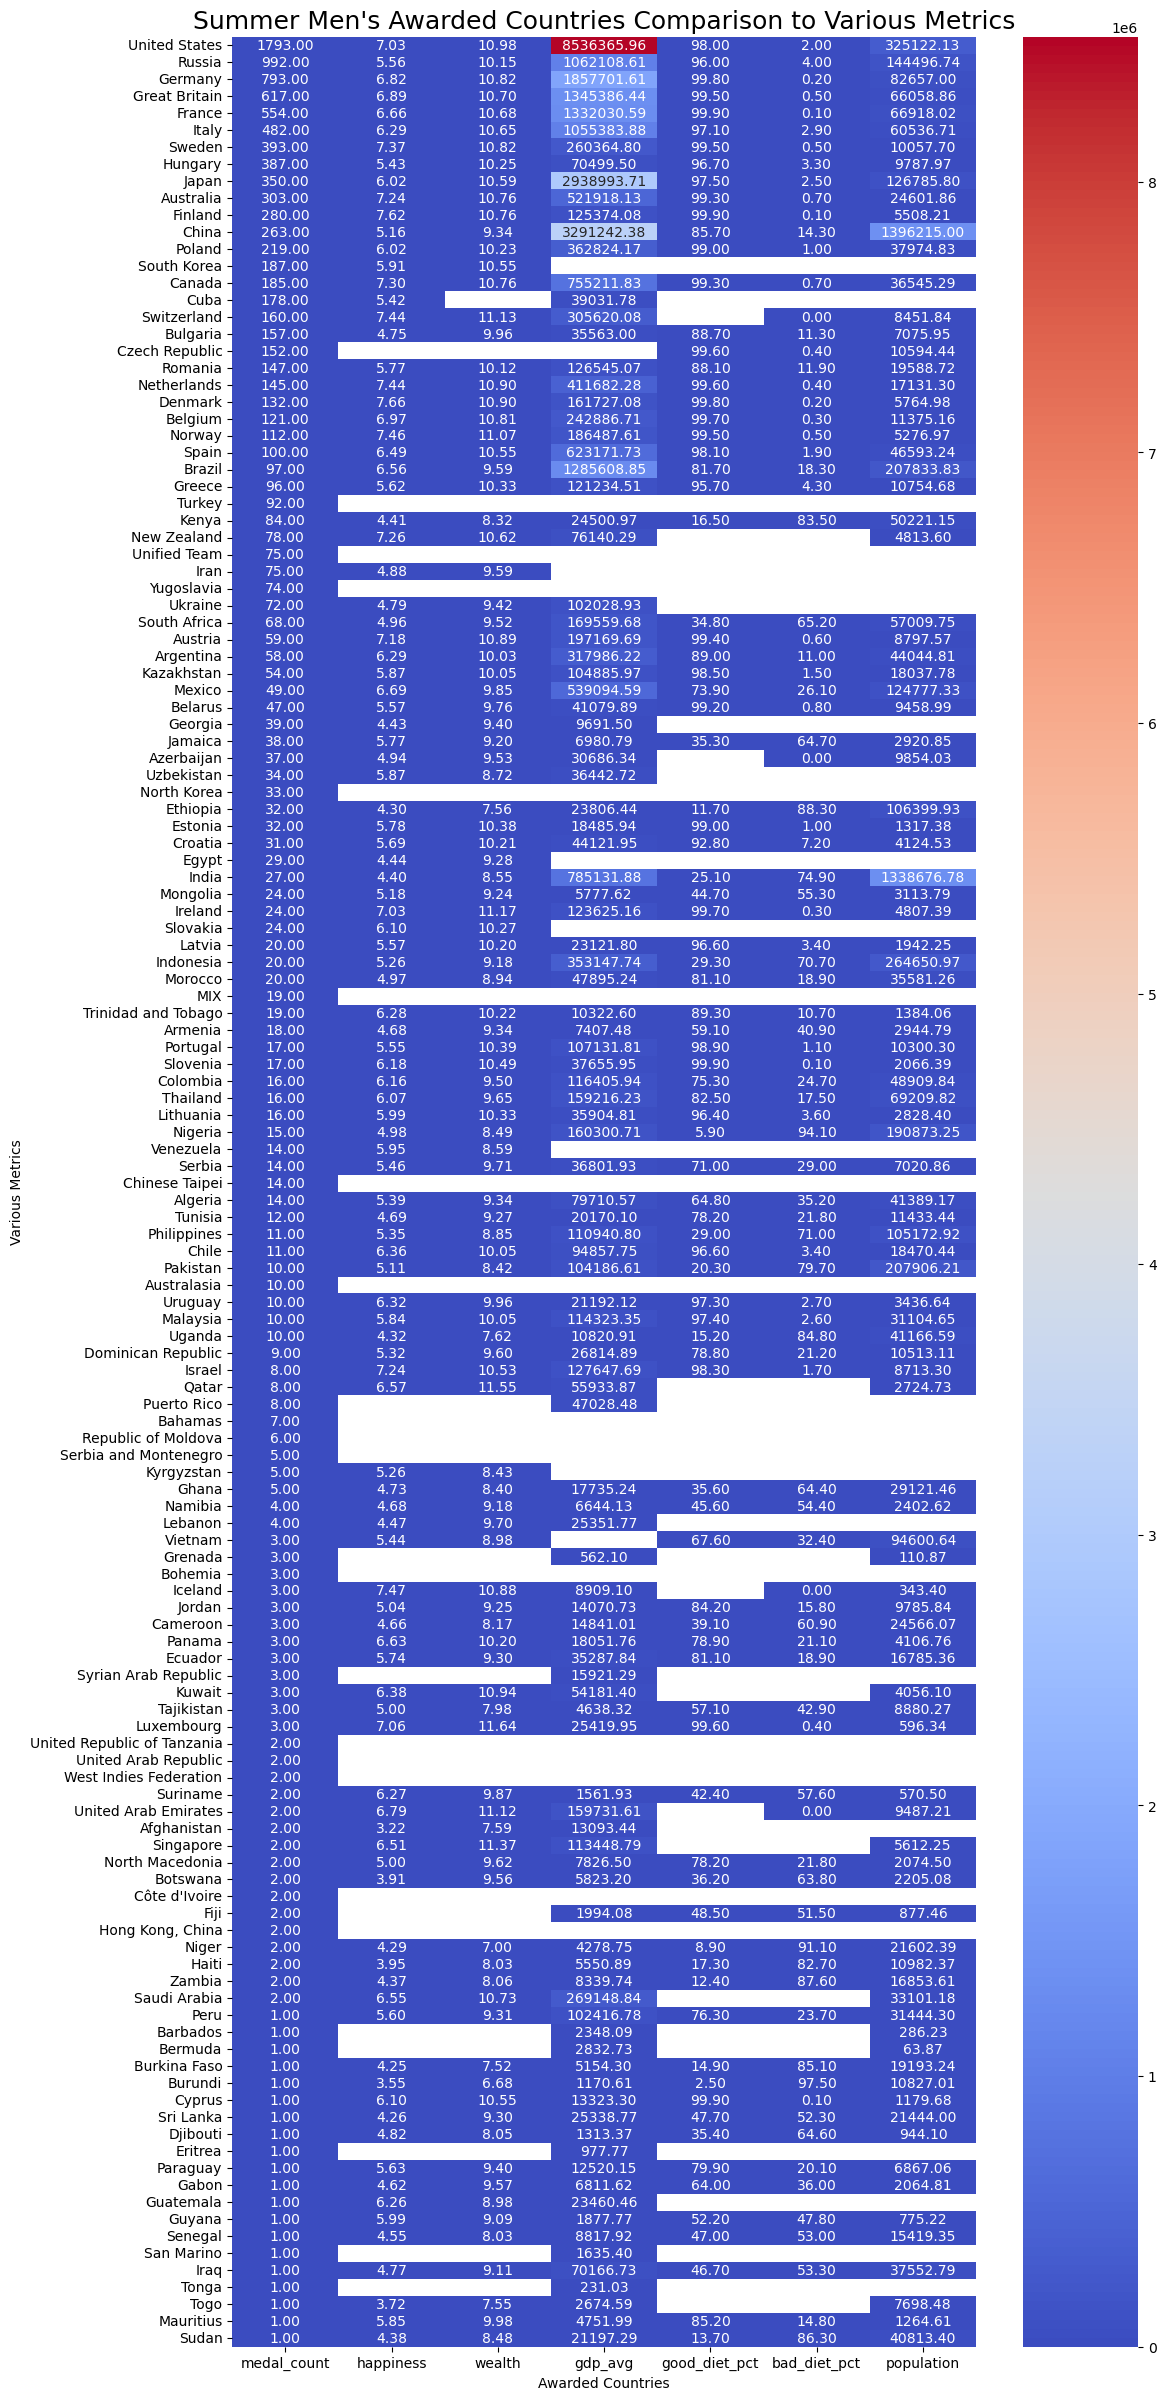

In [22]:
plt.figure(figsize=(12, 30))

# Create a heatmap
ax = sns.heatmap(df_country_compare_men_summer, annot=True, annot_kws={"size": 10}, cmap='coolwarm', fmt=".2f")
ax.set_xlabel("Awarded Countries")
ax.set_ylabel("Various Metrics")
plt.title('Summer Men\'s Awarded Countries Comparison to Various Metrics', fontsize=18)
plt.show()

In [23]:
# Men's Winter games correlation
data_to_select = {
    'game_season': 'Winter', 
    'event_gender': 'Men'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.info()
df.set_index('country_name').corr()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_name   38 non-null     object 
 1   medal_count    38 non-null     int64  
 2   happiness      33 non-null     float64
 3   wealth         33 non-null     float64
 4   gdp_avg        32 non-null     float64
 5   good_diet_pct  29 non-null     float64
 6   bad_diet_pct   30 non-null     float64
 7   population     31 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.5+ KB


,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
medal_count,1.000000,0.500560,0.441564,0.298308,0.270163,-0.280353,-0.000049
happiness,0.500560,1.000000,0.856339,0.069879,0.676905,-0.682786,-0.285016
wealth,0.441564,0.856339,1.000000,0.081644,0.668249,-0.674269,-0.453117
gdp_avg,0.298308,0.069879,0.081644,1.000000,-0.100535,0.108115,0.498329
good_diet_pct,0.270163,0.676905,0.668249,-0.100535,1.000000,-1.000000,-0.571902
bad_diet_pct,-0.280353,-0.682786,-0.674269,0.108115,-1.000000,1.000000,0.573609
population,-0.000049,-0.285016,-0.453117,0.498329,-0.571902,0.573609,1.000000


In [24]:
# Top and Bottom Mens Winter Games
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='medal_count', ascending=False).reset_index(drop=True)
display(df.head())
display(df.tail())

,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,Norway,318,7.463886,11.074348,186487.61,99.5,0.5,5276.968
1,Germany,189,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
2,Russia,173,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
3,United States,167,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
4,Austria,153,7.178953,10.889285,197169.69,99.4,0.6,8797.566


,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
33,New Zealand,2,7.260700,10.617803,76140.29,NaN,NaN,4813.600
34,Luxembourg,2,7.058734,11.643438,25419.95,99.6,0.4,596.336
35,Ukraine,2,4.785123,9.421713,102028.93,NaN,NaN,NaN
36,Romania,1,5.770220,10.115109,126545.07,88.1,11.9,19588.715
37,Bulgaria,1,4.751980,9.961130,35563.00,88.7,11.3,7075.947


In [25]:
# Set index to country_name and adjust for floats

df.set_index('country_name', inplace=True)

df_country_compare_men_winter = df.astype(float)

df_country_compare_men_winter

,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
country_name,,,,,,,
Norway,318.0,7.463886,11.074348,186487.61,99.5,0.5,5276.968
Germany,189.0,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
Russia,173.0,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
United States,167.0,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
Austria,153.0,7.178953,10.889285,197169.69,99.4,0.6,8797.566
Finland,124.0,7.624132,10.761079,125374.08,99.9,0.1,5508.214
Sweden,117.0,7.365232,10.822531,260364.80,99.5,0.5,10057.698
Switzerland,109.0,7.435587,11.125057,305620.08,NaN,0.0,8451.840
Canada,105.0,7.296854,10.756211,755211.83,99.3,0.7,36545.295


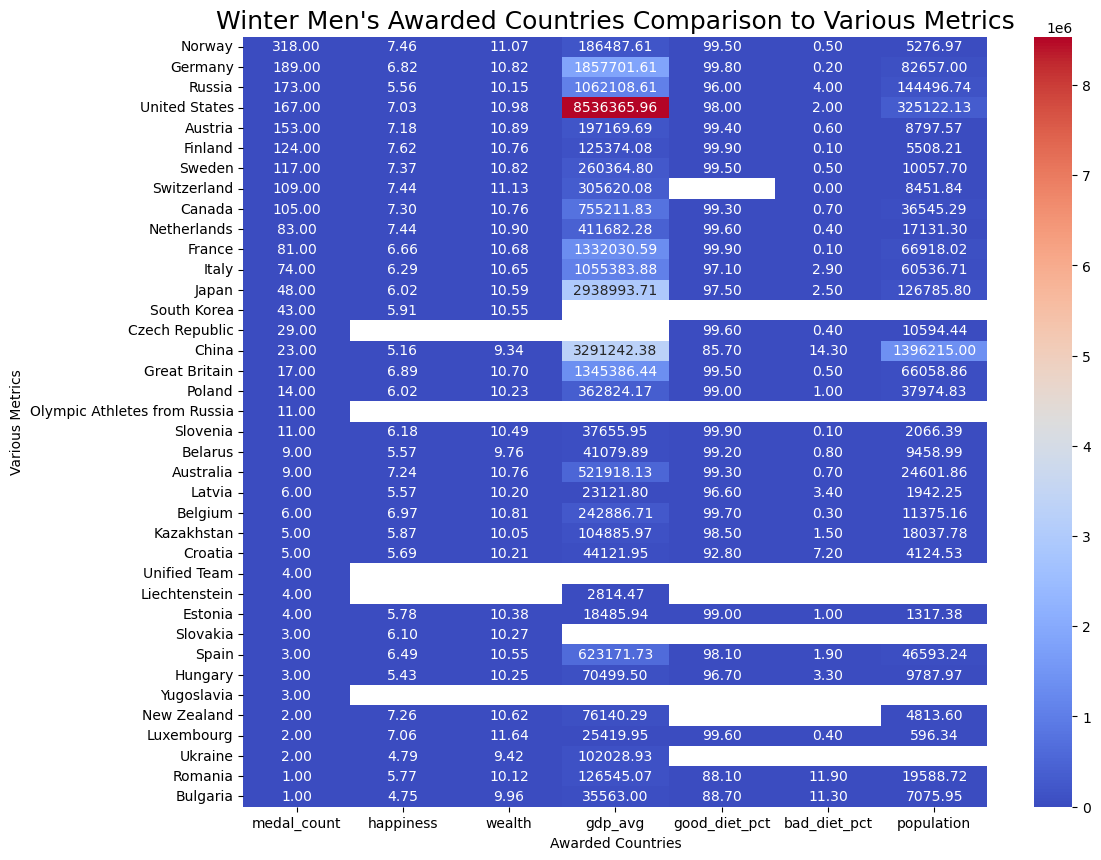

In [26]:
plt.figure(figsize=(12, 10))

# Create a heatmap
ax = sns.heatmap(df_country_compare_men_winter, annot=True, annot_kws={"size": 10}, cmap='coolwarm', fmt=".2f")
ax.set_xlabel("Awarded Countries")
ax.set_ylabel("Various Metrics")
plt.title('Winter Men\'s Awarded Countries Comparison to Various Metrics', fontsize=18)
plt.show()

## General Heatmap Exploration

In [27]:
print(df.columns)

Index(['medal_count', 'happiness', 'wealth', 'gdp_avg', 'good_diet_pct',
       'bad_diet_pct', 'population'],
      dtype='object')


<Axes: xlabel='happiness', ylabel='medal_count'>

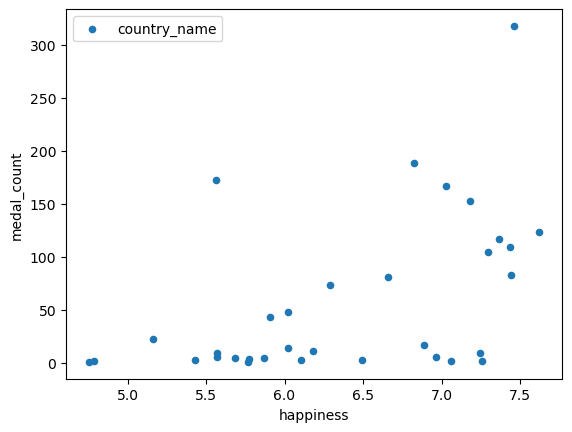

In [28]:
df.plot.scatter(x='happiness', y='medal_count', label='country_name')

KeyError: 'country_name'

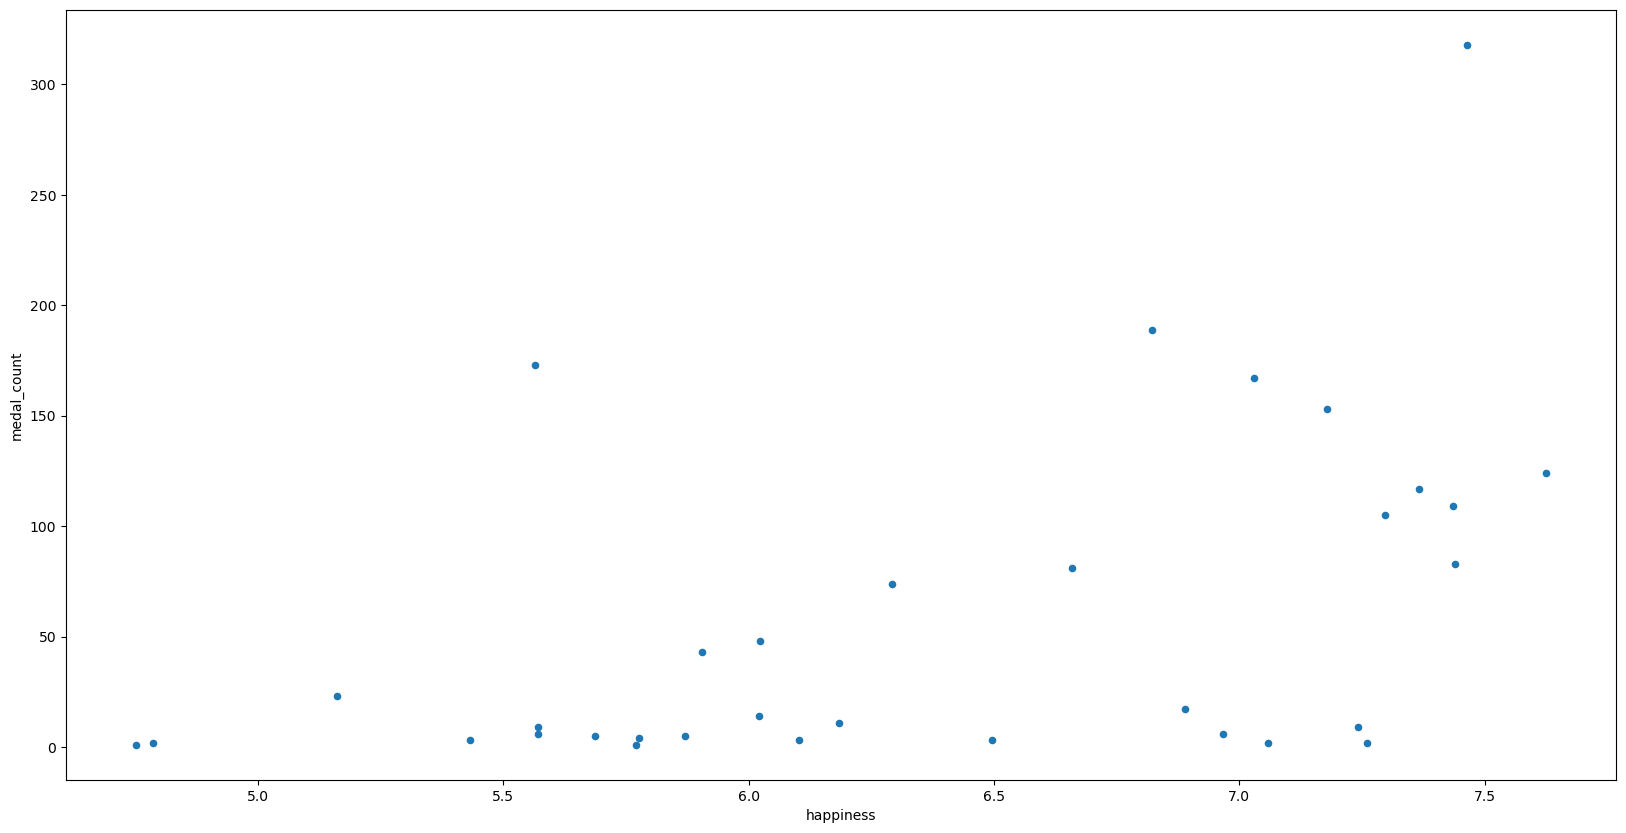

In [31]:
ax = df.plot(x='happiness', y='medal_count', kind='scatter', figsize=(20, 10))
for i, row in df.iterrows():
    ax.annotate(row['country_name'], (row['happiness'], row['medal_count']), rotation=30, fontsize=9, textcoords="offset points", xytext=(10,5), ha='center')
plt.show()

In [32]:
df_medal_details

,game_season,country_code,country_name,discipline_title,event_title,event_gender,medal_type,medal_count
0,Summer,AFG,Afghanistan,Taekwondo,58 - 68 kg men,Men,BRONZE,1
1,Summer,AFG,Afghanistan,Taekwondo,beijing 2008 taekwondo - 58 kg men,Men,BRONZE,1
2,Summer,AHO,Netherlands Antilles,Sailing,division ii - windsurfer men,Open,SILVER,1
3,Summer,ALG,Algeria,Athletics,1500m men,Men,GOLD,2
4,Summer,ALG,Algeria,Athletics,1500m men,Men,SILVER,1
...,...,...,...,...,...,...,...,...
13125,Winter,UZB,Uzbekistan,Freestyle Skiing,aerials women,Women,GOLD,1
13126,Winter,YUG,Yugoslavia,Alpine Skiing,giant slalom men,Men,SILVER,1
13127,Winter,YUG,Yugoslavia,Alpine Skiing,slalom women,Women,SILVER,1
13128,Winter,YUG,Yugoslavia,Ski Jumping,large hill individual men,Men,BRONZE,1


In [33]:
df_medal_counts = df_medal_details.groupby('country_name')['medal_count'].sum().reset_index()
df_medal_counts


,country_name,medal_count
0,Afghanistan,2
1,Algeria,17
2,Argentina,77
3,Armenia,18
4,Australasia,12
...,...,...
143,"Virgin Islands, US",1
144,West Indies Federation,2
145,Yugoslavia,87
146,Zambia,2


In [34]:
df_country_details = pd.read_csv('../data/etl/merged_medal_hap_nut_gdp_by_country.csv')

In [35]:
df_country_details

,country_name,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population,gdp_avg
0,Afghanistan,2,3.219917,7.585624,0.476654,52.711667,0.480475,0.056325,0.835824,0.421804,0.370840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13093.44
1,Netherlands Antilles,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,17,5.391880,9.338236,0.811683,66.136363,0.520711,-0.132543,0.688052,0.540448,0.266245,0.2,7.2,64.8,35.2,0.1,3.0,14.6,41389.174,79710.57
3,Australasia,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Argentina,77,6.289722,10.028808,0.901894,66.700000,0.777786,-0.153203,0.839019,0.737995,0.288382,0.3,7.1,89.0,11.0,0.1,3.1,4.8,44044.811,317986.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,Vietnam,4,5.437579,8.977185,0.827434,64.900000,0.898700,-0.024657,0.771082,0.623233,0.204675,1.3,15.9,67.6,32.4,1.2,15.1,30.7,94600.643,NaN
150,West Indies Federation,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,Yugoslavia,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,Zambia,2,4.365957,8.058288,0.725218,52.047059,0.774665,0.020810,0.821056,0.676104,0.302208,63.8,81.8,12.4,87.6,10.7,13.8,14.8,16853.608,8339.74


In [36]:
display(df_country_details)

"""
IMPORTANT NOTES:
In preparation for the correlative analysis, I scoured the dataset and found some things that will impact the overall findings:
• Duplicative Czech Republic with differing medal counts
• Not alphabetically sorted (e.g. Virgin Islands is under "I" and North Korea is under "N" but South Korea is under "K")
• Korea North and South are separated (does not account for pre-separatist movement, no Republic of Korea to be found)
• "MIX" has 23 medals but unknown what it actually is (mixed team designation) — this is not a country, and therefore we do not include it in the dataset based on our existing parameters
• "Unified team" has 135 medals, also not a country and does not fit into our filtering / models
• West Indies Federation and Yugoslavia do not exist anymore and therefore cannot be reconciled with the comparative data which accounts for more recent years
"""

,country_name,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population,gdp_avg
0,Afghanistan,2,3.219917,7.585624,0.476654,52.711667,0.480475,0.056325,0.835824,0.421804,0.370840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13093.44
1,Netherlands Antilles,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,17,5.391880,9.338236,0.811683,66.136363,0.520711,-0.132543,0.688052,0.540448,0.266245,0.2,7.2,64.8,35.2,0.1,3.0,14.6,41389.174,79710.57
3,Australasia,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Argentina,77,6.289722,10.028808,0.901894,66.700000,0.777786,-0.153203,0.839019,0.737995,0.288382,0.3,7.1,89.0,11.0,0.1,3.1,4.8,44044.811,317986.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,Vietnam,4,5.437579,8.977185,0.827434,64.900000,0.898700,-0.024657,0.771082,0.623233,0.204675,1.3,15.9,67.6,32.4,1.2,15.1,30.7,94600.643,NaN
150,West Indies Federation,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,Yugoslavia,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,Zambia,2,4.365957,8.058288,0.725218,52.047059,0.774665,0.020810,0.821056,0.676104,0.302208,63.8,81.8,12.4,87.6,10.7,13.8,14.8,16853.608,8339.74


'\nIMPORTANT NOTES:\nIn preparation for the correlative analysis, I scoured the dataset and found some things that will impact the overall findings:\n• Duplicative Czech Republic with differing medal counts\n• Not alphabetically sorted (e.g. Virgin Islands is under "I" and North Korea is under "N" but South Korea is under "K")\n• Korea North and South are separated (does not account for pre-separatist movement, no Republic of Korea to be found)\n• "MIX" has 23 medals but unknown what it actually is (mixed team designation) — this is not a country, and therefore we do not include it in the dataset based on our existing parameters\n• "Unified team" has 135 medals, also not a country and does not fit into our filtering / models\n• West Indies Federation and Yugoslavia do not exist anymore and therefore cannot be reconciled with the comparative data which accounts for more recent years\n'

,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population,gdp_avg
medal_count,1.000000,0.355586,0.357803,0.291602,0.284972,0.175840,0.144428,-0.198347,0.164676,-0.204697,-0.160419,-0.301940,0.356910,-0.343019,-0.052136,-0.052336,-0.047440,0.229562,0.858683
happiness,0.355586,1.000000,0.816091,0.762118,0.763315,0.652632,0.325894,-0.562221,0.601594,-0.372836,-0.445801,-0.701876,0.761900,-0.754073,-0.192630,-0.208925,-0.212301,-0.116704,0.237327
wealth,0.357803,0.816091,1.000000,0.730850,0.816775,0.497857,0.092069,-0.458153,0.298551,-0.279036,-0.552569,-0.872884,0.895549,-0.892065,-0.246917,-0.218126,-0.219779,-0.103476,0.248334
support,0.291602,0.762118,0.730850,1.000000,0.646804,0.499487,0.134438,-0.292140,0.488799,-0.486312,-0.501859,-0.691144,0.730155,-0.720806,-0.217100,-0.328746,-0.341011,-0.185146,0.182812
health,0.284972,0.763315,0.816775,0.646804,1.000000,0.430558,0.050002,-0.350378,0.280501,-0.190660,-0.607838,-0.853124,0.851832,-0.846876,-0.293222,-0.177807,-0.173161,-0.043193,0.195896
freedom,0.175840,0.652632,0.497857,0.499487,0.430558,1.000000,0.396809,-0.548813,0.704620,-0.411330,-0.282297,-0.346318,0.388841,-0.401372,-0.082066,0.008591,0.001200,0.052297,0.148059
generosity,0.144428,0.325894,0.092069,0.134438,0.050002,0.396809,1.000000,-0.373938,0.401587,-0.161033,0.060758,0.093614,-0.110418,0.083391,0.101863,0.084913,0.086993,-0.015731,0.070355
corruption,-0.198347,-0.562221,-0.458153,-0.292140,-0.350378,-0.548813,-0.373938,1.000000,-0.316435,0.288833,0.159478,0.259364,-0.289108,0.316306,0.137014,0.099960,0.104769,0.118001,-0.078551
positivity,0.164676,0.601594,0.298551,0.488799,0.280501,0.704620,0.401587,-0.316435,1.000000,-0.361892,-0.023155,-0.092354,0.170789,-0.175315,0.066444,-0.056769,-0.068174,-0.013906,0.145508
negativity,-0.204697,-0.372836,-0.279036,-0.486312,-0.190660,-0.411330,-0.161033,0.288833,-0.361892,1.000000,0.077849,0.231419,-0.259882,0.276438,0.019136,0.122149,0.119779,-0.040990,-0.146909


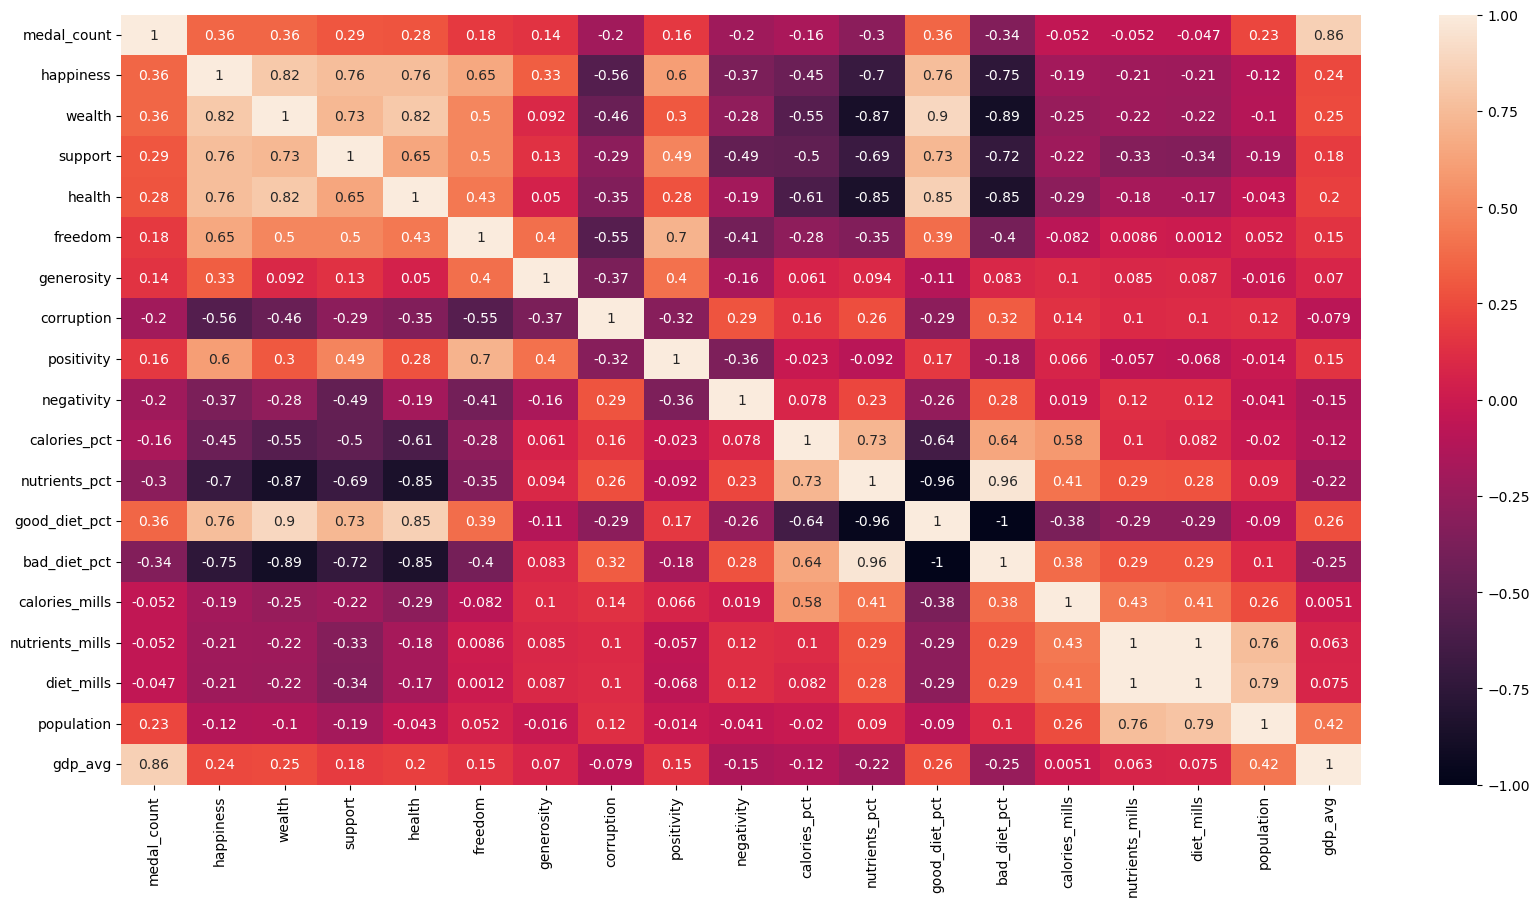

In [37]:
# general heatmap correlation of all variables
# data correlation matrix

plt.figure(figsize=(20, 10))
df_corr =df_country_details.drop('country_name', axis=1).corr()
sns.heatmap(df_corr, annot=True)

df_corr


,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population,gdp_avg
medal_count,1.000000,0.355586,0.357803,0.291602,0.284972,0.175840,0.144428,-0.198347,0.164676,-0.204697,-0.160419,-0.301940,0.356910,-0.343019,-0.052136,-0.052336,-0.047440,0.229562,0.858683
happiness,0.355586,1.000000,0.816091,0.762118,0.763315,0.652632,0.325894,-0.562221,0.601594,-0.372836,-0.445801,-0.701876,0.761900,-0.754073,-0.192630,-0.208925,-0.212301,-0.116704,0.237327
wealth,0.357803,0.816091,1.000000,0.730850,0.816775,0.497857,0.092069,-0.458153,0.298551,-0.279036,-0.552569,-0.872884,0.895549,-0.892065,-0.246917,-0.218126,-0.219779,-0.103476,0.248334
support,0.291602,0.762118,0.730850,1.000000,0.646804,0.499487,0.134438,-0.292140,0.488799,-0.486312,-0.501859,-0.691144,0.730155,-0.720806,-0.217100,-0.328746,-0.341011,-0.185146,0.182812
health,0.284972,0.763315,0.816775,0.646804,1.000000,0.430558,0.050002,-0.350378,0.280501,-0.190660,-0.607838,-0.853124,0.851832,-0.846876,-0.293222,-0.177807,-0.173161,-0.043193,0.195896
freedom,0.175840,0.652632,0.497857,0.499487,0.430558,1.000000,0.396809,-0.548813,0.704620,-0.411330,-0.282297,-0.346318,0.388841,-0.401372,-0.082066,0.008591,0.001200,0.052297,0.148059
generosity,0.144428,0.325894,0.092069,0.134438,0.050002,0.396809,1.000000,-0.373938,0.401587,-0.161033,0.060758,0.093614,-0.110418,0.083391,0.101863,0.084913,0.086993,-0.015731,0.070355
corruption,-0.198347,-0.562221,-0.458153,-0.292140,-0.350378,-0.548813,-0.373938,1.000000,-0.316435,0.288833,0.159478,0.259364,-0.289108,0.316306,0.137014,0.099960,0.104769,0.118001,-0.078551
positivity,0.164676,0.601594,0.298551,0.488799,0.280501,0.704620,0.401587,-0.316435,1.000000,-0.361892,-0.023155,-0.092354,0.170789,-0.175315,0.066444,-0.056769,-0.068174,-0.013906,0.145508
negativity,-0.204697,-0.372836,-0.279036,-0.486312,-0.190660,-0.411330,-0.161033,0.288833,-0.361892,1.000000,0.077849,0.231419,-0.259882,0.276438,0.019136,0.122149,0.119779,-0.040990,-0.146909


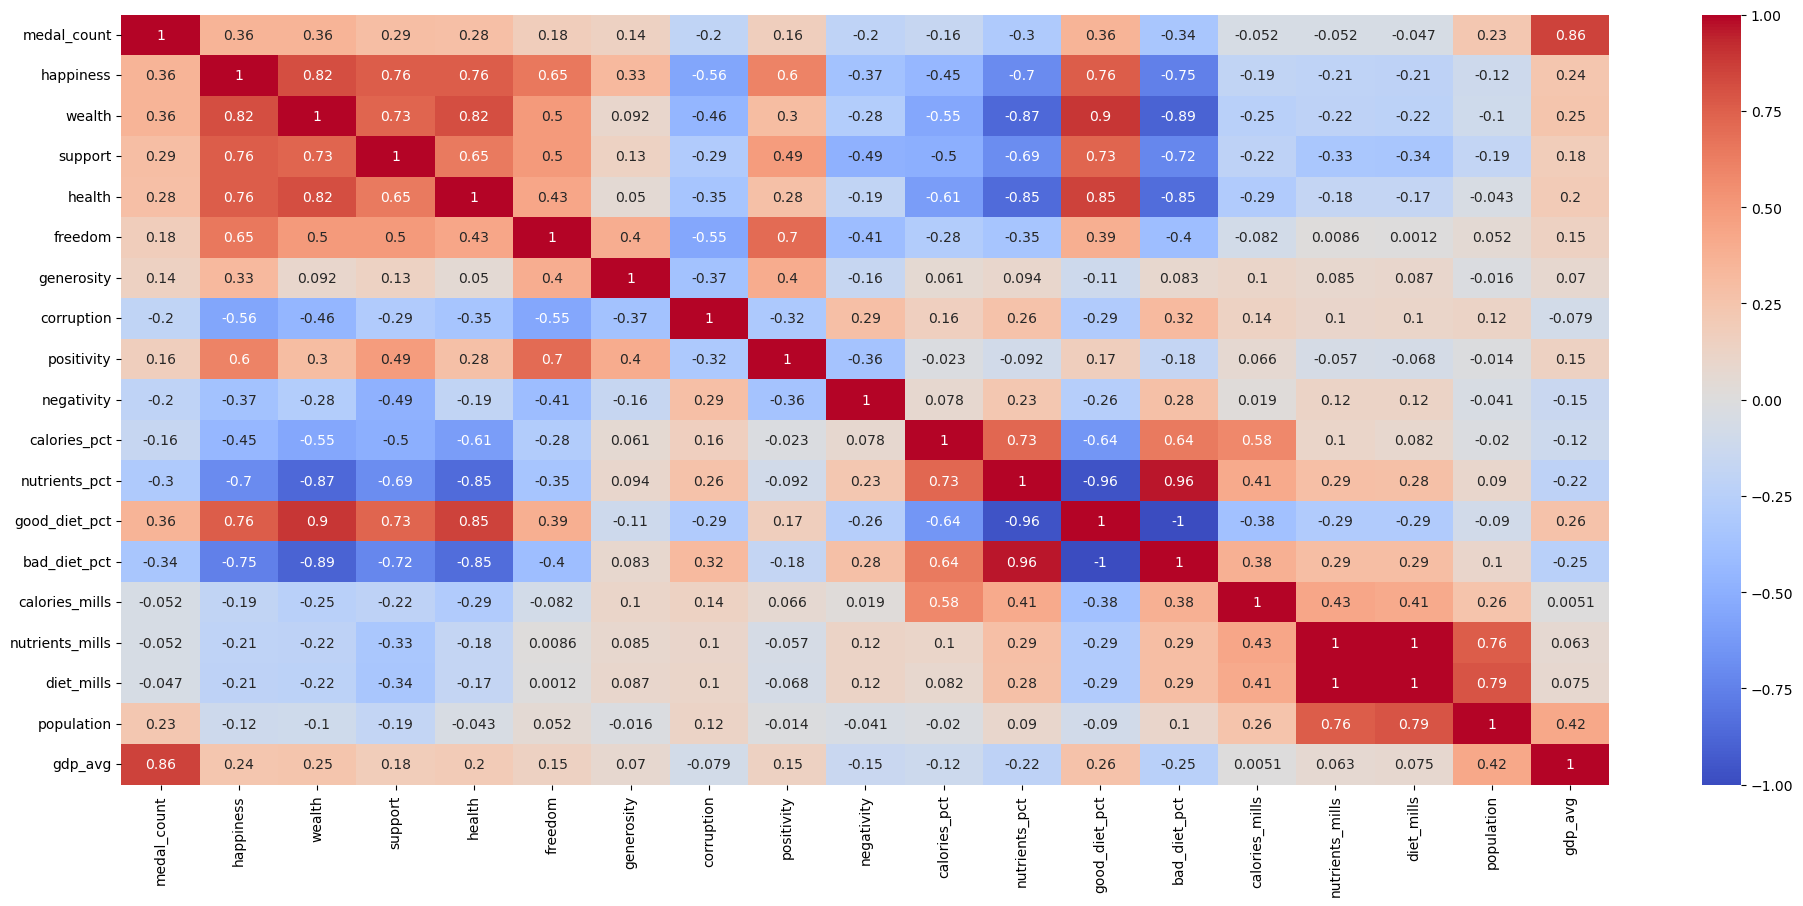

In [38]:
# general heatmap correlation of all variables, adjusted tones
#Clean up labels names

plt.figure(figsize=(24, 10))
df_corr =df_country_details.drop('country_name', axis=1).corr()
sns.heatmap(df_corr, cmap='coolwarm', annot=True)

df_corr


,medal_count,happiness,wealth,health,gdp_avg,good_diet_pct
medal_count,1.000000,0.355586,0.357803,0.284972,0.858683,0.356910
happiness,0.355586,1.000000,0.816091,0.763315,0.237327,0.761900
wealth,0.357803,0.816091,1.000000,0.816775,0.248334,0.895549
health,0.284972,0.763315,0.816775,1.000000,0.195896,0.851832
gdp_avg,0.858683,0.237327,0.248334,0.195896,1.000000,0.259833
good_diet_pct,0.356910,0.761900,0.895549,0.851832,0.259833,1.000000


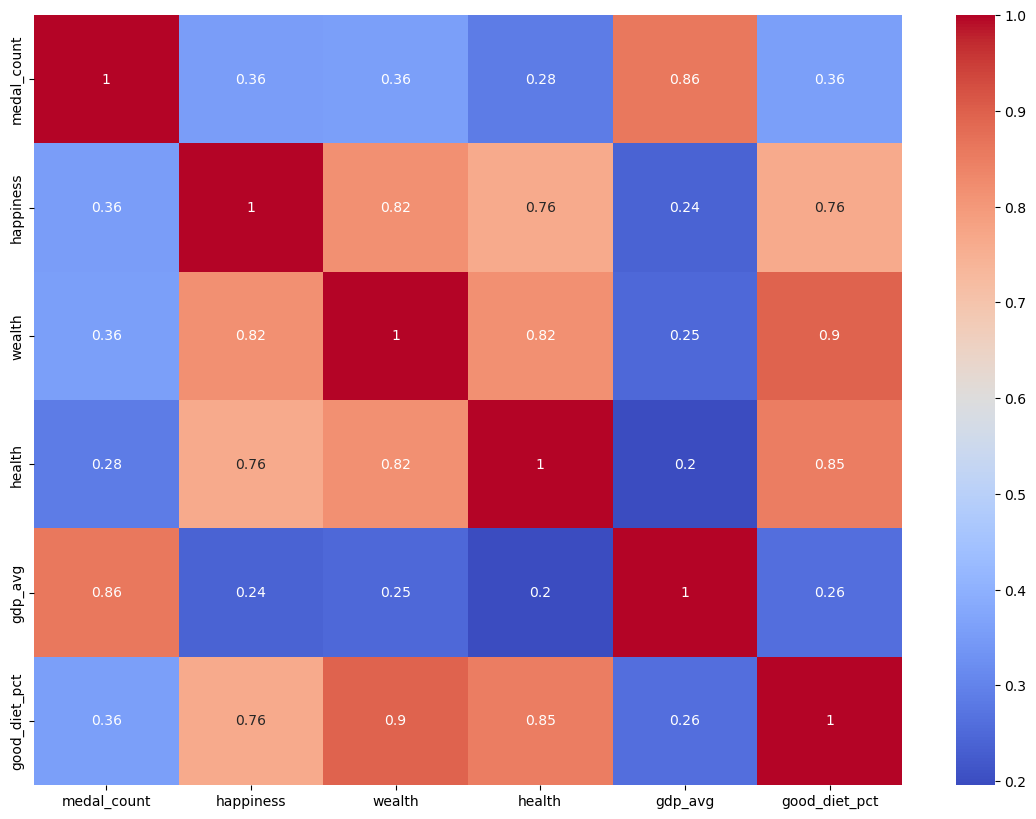

In [39]:
# Simplify heatmap to medals, happiness, wealth, health, gdp and good diet

plt.figure(figsize=(14, 10))
df_corr =df_country_details[['medal_count', 'happiness', 'wealth', 'health', 'gdp_avg', 'good_diet_pct']].corr()
sns.heatmap(df_corr, cmap='coolwarm', annot=True)

df_corr


Research
Website: https://towardsdatascience.com/all-about-heatmaps-bb7d97f099d7

"Correlogram: A correlogram replaces each of the variables on the two axes with numeric variables in the dataset. Each square depicts the relationship between the two intersecting variables, which helps to build descriptive or predictive statistical models."

"Spatial Heatmap: Each square in a Heatmap is assigned a color representation according to the nearby cells’ value. The location of color is according to the magnitude of the value in that particular space. These Heatmaps are data-driven “paint by numbers” canvas overlaid on top of an image. The cells with higher values than other cells are given a hot color, while cells with lower values are assigned a cold color."


In [ ]:
df_corr


,Medals Won,Happiness,Wealth,Health,GDP per Capita,Good Diet %
medal_count,1.000000,0.355586,0.357803,0.284972,0.858683,0.356910
happiness,0.355586,1.000000,0.816091,0.763315,0.237327,0.761900
wealth,0.357803,0.816091,1.000000,0.816775,0.248334,0.895549
health,0.284972,0.763315,0.816775,1.000000,0.195896,0.851832
gdp_avg,0.858683,0.237327,0.248334,0.195896,1.000000,0.259833
good_diet_pct,0.356910,0.761900,0.895549,0.851832,0.259833,1.000000


Index(['Medals Won', 'Happiness', 'Wealth', 'Health', 'GDP per Capita',
       'Good Diet %'],
      dtype='object')


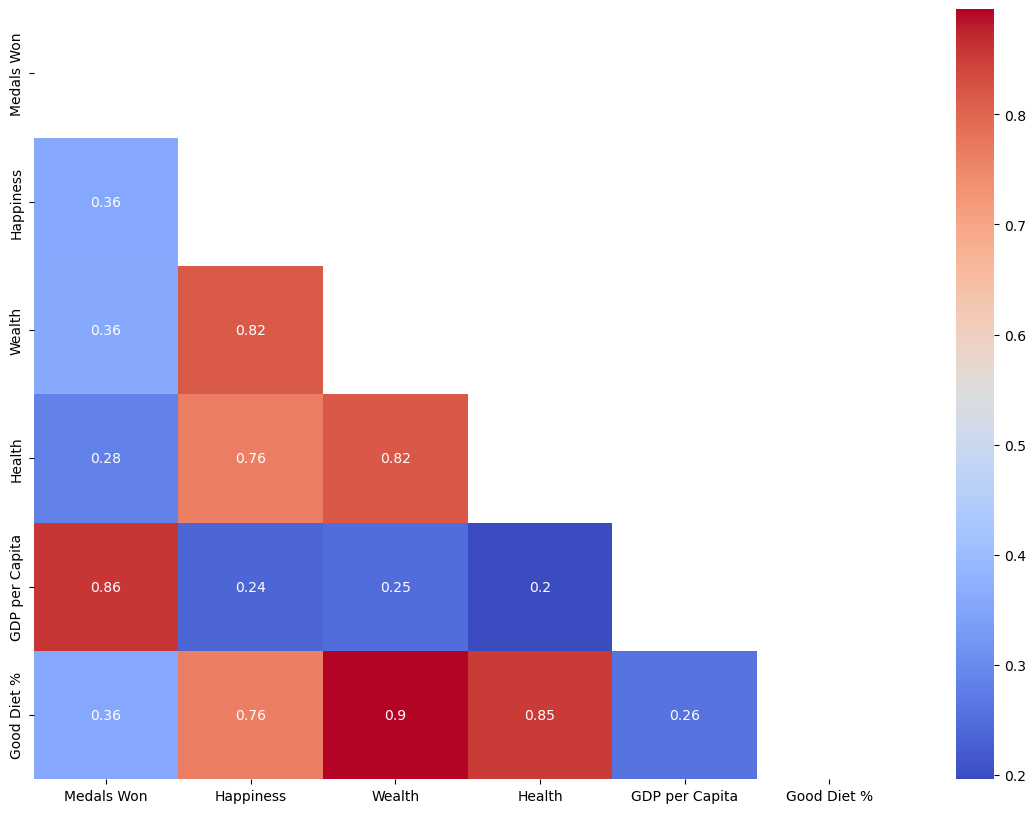

In [ ]:
# Adjusting heatmpap to triangle

plt.figure(figsize=(14, 10))
df_corr =df_country_details[['medal_count', 'happiness', 'wealth', 'health', 'gdp_avg', 'good_diet_pct']].corr()
df_corr.rename(columns={
    'medal_count': 'Medals Won',
    'happiness': 'Happiness',
    'wealth': 'Wealth',
    'health': 'Health',
    'gdp_avg': 'GDP per Capita',
    'good_diet_pct': 'Good Diet %'
}, inplace=True)

df_corr.rename(index={
    'medal_count': 'Medals Won',
    'happiness': 'Happiness',
    'wealth': 'Wealth',
    'health': 'Health',
    'gdp_avg': 'GDP per Capita',
    'good_diet_pct': 'Good Diet %'
}, inplace=True)

mask = np.triu(np.ones_like(df_corr, dtype=bool))
sns.heatmap(df_corr, mask=mask, cmap='coolwarm', annot=True)

print(df_corr.columns)


# Show the plot
plt.show()

Index(['Medals Won', 'Happiness', 'Wealth', 'Health', 'GDP per Capita',
       'Good Diet %'],
      dtype='object')


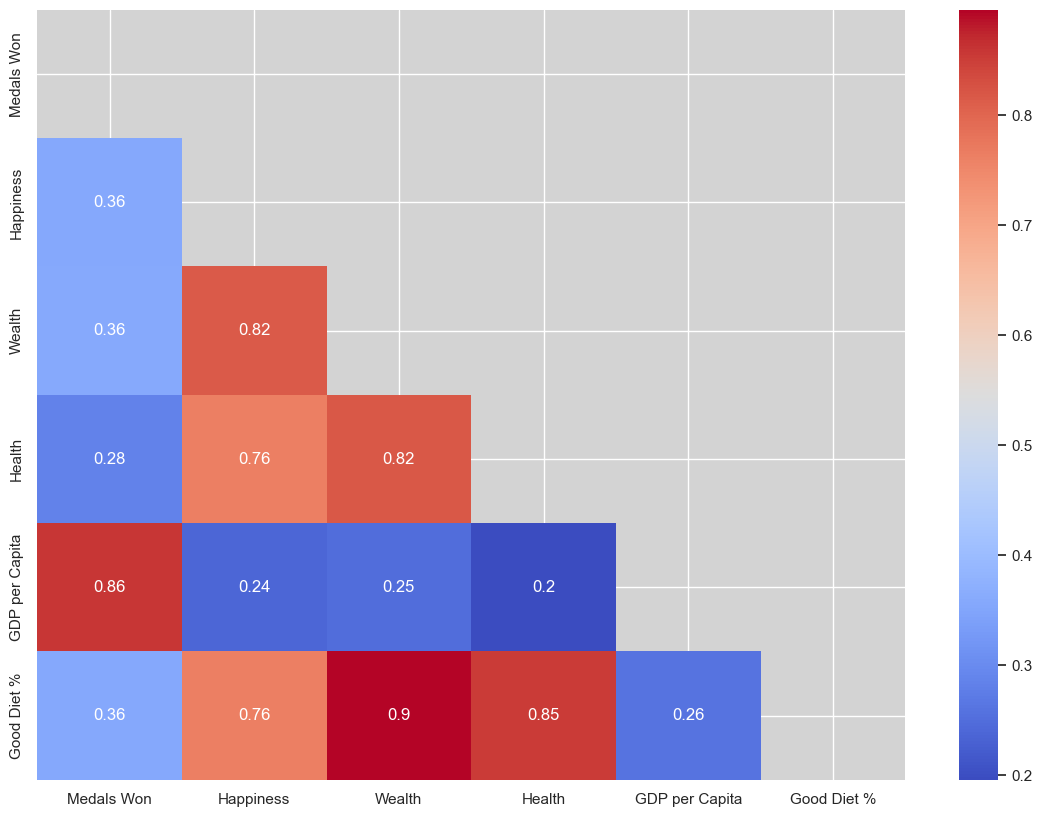

In [74]:
# Adjusting heatmpap to triangle

fig, ax = plt.subplots(figsize=(14, 10), facecolor='white')
df_corr =df_country_details[['medal_count', 'happiness', 'wealth', 'health', 'gdp_avg', 'good_diet_pct']].corr()
df_corr.rename(columns={
    'medal_count': 'Medals Won',
    'happiness': 'Happiness',
    'wealth': 'Wealth',
    'health': 'Health',
    'gdp_avg': 'GDP per Capita',
    'good_diet_pct': 'Good Diet %'
}, inplace=True)

df_corr.rename(index={
    'medal_count': 'Medals Won',
    'happiness': 'Happiness',
    'wealth': 'Wealth',
    'health': 'Health',
    'gdp_avg': 'GDP per Capita',
    'good_diet_pct': 'Good Diet %'
}, inplace=True)

mask = np.triu(np.ones_like(df_corr, dtype=bool))
sns.heatmap(df_corr, mask=mask, cmap='coolwarm', annot=True, edgecolor='none')
ax.set_facecolor('lightgrey')

print(df_corr.columns)

# Show the plot
plt.show()